In [1]:
!python --version

Python 3.8.18


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers ,regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import  models, callbacks

from tensorflow.keras.models import Sequential

In [2]:
data_dir= './drug_images'
batch_size = 3
img_height = 180
img_width = 180

In [3]:
(train_ds,val_ds) = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  labels='inferred',
  label_mode='int',
  class_names=None,
  color_mode='rgb',
  batch_size=2,
  image_size=(img_height, img_width),
  shuffle=True,
  seed=123,
  validation_split=0.2,
  subset="both",
  interpolation='bilinear',
  follow_links=False,
  crop_to_aspect_ratio=False)
print(type(train_ds))

Found 16 files belonging to 2 classes.
Using 13 files for training.
Using 3 files for validation.
<class 'tensorflow.python.data.ops.batch_op._BatchDataset'>


In [4]:
class_names = train_ds.class_names


In [5]:
print(class_names)

['aspirin', 'ibuprofan']


In [6]:
print(train_ds)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


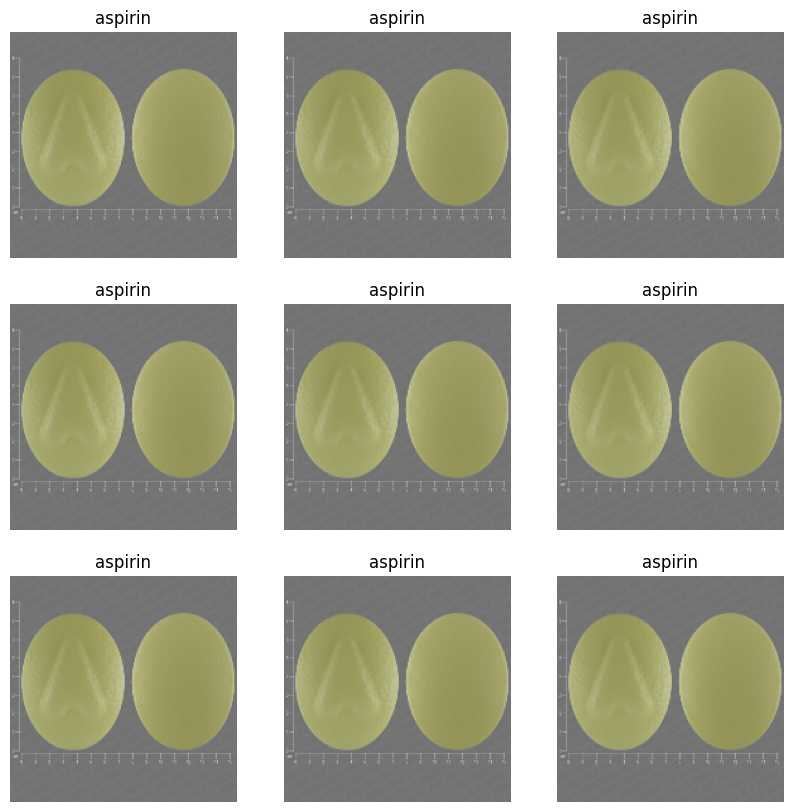

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    for j in range(2):
        plt.imshow(images[j].numpy().astype("uint8"))
        plt.title(class_names[labels[j]])
        plt.axis("off")

In [8]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(2, 180, 180, 3)
(2,)


In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
normalization_layer = layers.Rescaling(1./255)

In [11]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.39627472 0.86727464


In [12]:
def random_saturation(image):
    image = tf.image.random_saturation(image, lower=0.7, upper=1.3)
    return image
    
def random_color_jitter(image):
    image = tf.image.random_contrast(image, lower=0.2, upper=1.8)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_saturation(image, lower=0.2, upper=1.8)
    image = tf.image.random_hue(image, max_delta=0.2)
    return image
    
data_augmentation2 = keras.Sequential(
  [
    
    layers.Lambda(random_saturation, input_shape=(img_height, img_width, 3)),
    layers.Lambda(random_color_jitter, input_shape=(img_height, img_width, 3)),
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomCrop(img_height, img_width),
    layers.RandomTranslation(0.2, 0.2),
   layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2),

  ]   
)

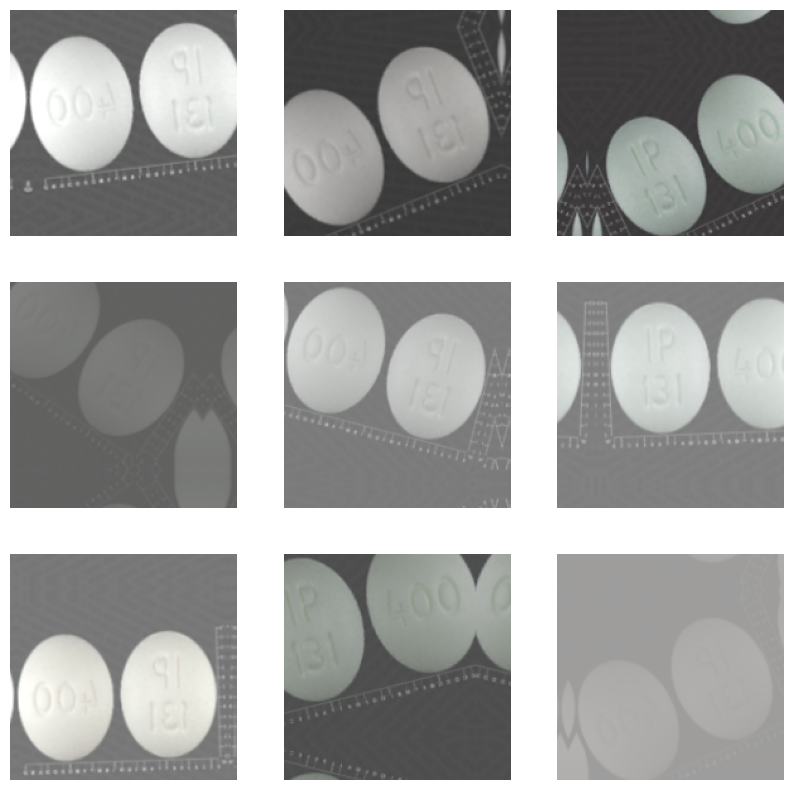

In [13]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(2):
  for i in range(9):
    augmented_images = data_augmentation2(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [14]:
# data_augmentation = keras.Sequential(
#     [
#         layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
#         layers.RandomRotation(0.2),
#         layers.RandomZoom(0.2),
#     ]
# )
num_classes = len(class_names)

# def random_saturation(image):
#     image = tf.image.random_saturation(image, lower=0.7, upper=1.3)
#     return image
    
# def random_color_jitter(image):
#     image = tf.image.random_contrast(image, lower=0.2, upper=1.8)
#     image = tf.image.random_brightness(image, max_delta=0.2)
#     image = tf.image.random_saturation(image, lower=0.2, upper=1.8)
#     image = tf.image.random_hue(image, max_delta=0.2)
#     return image

# data_augmentation = tf.keras.Sequential([
#     # layers.Lambda(random_saturation, input_shape=(img_height, img_width, 3)),
#     # layers.Lambda(random_color_jitter, input_shape=(img_height, img_width, 3)),

#     layers.RandomFlip("horizontal"),
#     layers.RandomRotation(0.2),
#     layers.RandomZoom(0.2),
#     layers.RandomContrast(0.2),
#     layers.RandomBrightness(0.2),
#     layers.RandomCrop(img_height, img_width),
#     layers.RandomHeight(0.2),
#     layers.RandomWidth(0.2),
#     layers.RandomTranslation(0.2, 0.2),
#     layers.Rescaling(1./255)
# ])
    # use randombrightness, random contrast, random crop, randomflip, reandomheight, random rotation, random translation,random width, random zoom 
    # Add any other aggressive transformations you want to experiment with





# Model architecture with dropout
# model = models.Sequential([
#     keras.Input(shape=(180, 180, 3)),
#     data_augmentation,
#     layers.Rescaling(1./255),
#     layers.Conv2D(16, 3, padding='same', activation='relu'),
#     layers.MaxPooling2D(),
#     layers.Conv2D(32, 3, padding='same', activation='relu'),
#     layers.MaxPooling2D(),
#     layers.Conv2D(64, 3, padding='same', activation='relu'),
#     layers.MaxPooling2D(),
#     layers.Flatten(),
#     layers.Dropout(0.5),
#     layers.Dense(128, activation='relu'),
#     layers.Dropout(0.5),
#     layers.Dense(num_classes)
# ])

# # Compile the model
# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])

# model = models.Sequential([
#     keras.Input(shape=(180, 180, 3)),
#     data_augmentation,
#     layers.Rescaling(1./255),
#     layers.Conv2D(16, 3, padding='same', activation='relu'),
#     layers.BatchNormalization(),
#     layers.MaxPooling2D(),
#     layers.Conv2D(32, 3, padding='same', activation='relu'),
#     layers.BatchNormalization(),
#     layers.MaxPooling2D(),
#     layers.Conv2D(64, 3, padding='same', activation='relu'),
#     layers.BatchNormalization(),
#     layers.MaxPooling2D(),
#     layers.Flatten(),
#     layers.Dropout(0.5),
#     layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
#     layers.BatchNormalization(),
#     layers.Dropout(0.5),
#     layers.Dense(num_classes)
# ])




# def random_saturation(image):
#     image = tf.image.random_saturation(image, lower=0.7, upper=1.3)
#     return image
    
# def random_color_jitter(image):
#     image = tf.image.random_contrast(image, lower=0.2, upper=1.8)
#     image = tf.image.random_brightness(image, max_delta=0.2)
#     image = tf.image.random_saturation(image, lower=0.2, upper=1.8)
#     image = tf.image.random_hue(image, max_delta=0.2)
#     return image
    
# data_augmentation2 = keras.Sequential(
#   [
    
#     layers.Lambda(random_saturation, input_shape=(img_height, img_width, 3)),
#     layers.Lambda(random_color_jitter, input_shape=(img_height, img_width, 3)),
#     layers.RandomFlip("horizontal",
#                       input_shape=(img_height,
#                                   img_width,
#                                   3)),
#     layers.RandomRotation(0.1),
#     layers.RandomZoom(0.1),
#     layers.RandomCrop(img_height, img_width),
#     layers.RandomTranslation(0.2, 0.2),
#    layers.RandomContrast(0.2),
#     layers.RandomBrightness(0.2),

#   ]   
# )


model = Sequential([
    keras.Input(shape=(180, 180, 3)),
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

    data_augmentation2,
    layers.Conv2D(32, 3, padding='same', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Activation('relu'),  # Use Activation layer
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Activation('relu'),  # Use Activation layer
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Activation('relu'),  # Use Activation layer
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(num_classes)
])

# model = Sequential([
#     keras.Input(shape=(180, 180, 3)),
#     layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

#     data_augmentation,
#     layers.Conv2D(16, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(32, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(64, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Dropout(0.2),
#   layers.Flatten(),
#   layers.Dense(128, activation='relu'),
#   layers.Dense(num_classes, name="outputs")

    
    # layers.Conv2D(32, 3, padding='same', kernel_regularizer=regularizers.l2(0.01)),
    # layers.BatchNormalization(),
    # layers.Activation('relu'),  # Use Activation layer
    # layers.MaxPooling2D(),
    # layers.Conv2D(64, 3, padding='same', kernel_regularizer=regularizers.l2(0.01)),
    # layers.BatchNormalization(),
    # layers.Activation('relu'),  # Use Activation layer
    # layers.MaxPooling2D(),
    # layers.Conv2D(128, 3, padding='same', kernel_regularizer=regularizers.l2(0.01)),
    # layers.BatchNormalization(),
    # layers.Activation('relu'),  # Use Activation layer
    # layers.MaxPooling2D(),
    # layers.Flatten(),
    # layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    # layers.Dropout(0.5),
    # layers.Dense(num_classes)
# ])

# layers.Conv2D(16, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(32, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(64, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Dropout(0.2),
#   layers.Flatten(),
#   layers.Dense(128, activation='relu'),
#   layers.Dense(num_classes, name="outputs")

# Compile the model

model.summary()
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


# Callbacks
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Training
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    # callbacks=[early_stopping] #if this is using cant plot the imgaes
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 180, 180, 32)      128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 180, 180, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 32)        0         
 D)                                                   

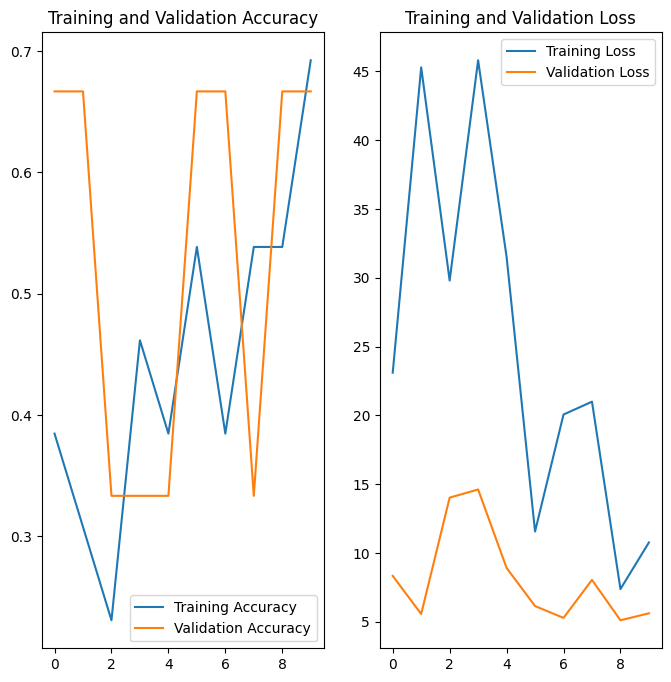

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [18]:
TF_MODEL_FILE_PATH = 'model.tflite' # The default path to the saved TensorFlow Lite model

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

In [19]:

interpreter.get_signature_list()



{'serving_default': {'inputs': ['sequential_12_input'],
  'outputs': ['outputs']}}

In [20]:
classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite

In [ ]:
predictions_lite = classify_lite(sequential_1_input=img_array)['outputs']
score_lite = tf.nn.softmax(predictions_lite)

In [15]:
model.save('my_model.h5')

/Users/liangshenghao/anaconda3/envs/myenv3/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [81]:
model.save('whole_model')

INFO:tensorflow:Assets written to: whole_model/assets


INFO:tensorflow:Assets written to: whole_model/assets


In [82]:
new_model2=tf.keras.models.load_model('whole_model')

In [83]:
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 180, 180, 32)      128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 180, 180, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 32)        0         
 D)                                                   

In [16]:
new_model = tf.keras.models.load_model('my_model.h5')

In [17]:
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 180, 180, 32)      128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 180, 180, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 32)        0         
 D)                                                   

In [19]:
# aspirin_url = "https://www.drugs.com/images/pills/nlm/50844-0600-01_NLMIMAGE10_CF38E7F7.jpg"
chlor_path = '/Users/liangshenghao/Projects/github/drug/chlorpheniramine.jpeg'
# print(aspirin_url)
# print(aspirin_path)
img = tf.keras.utils.load_img(
    chlor_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = new_model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 234ms/step
This image most likely belongs to aspirin with a 55.23 percent confidence.


In [23]:
# aspirin_url = "https://www.drugs.com/images/pills/nlm/50844-0600-01_NLMIMAGE10_CF38E7F7.jpg"
dog_path = '/Users/liangshenghao/Projects/github/drug/dog.jpeg'
# print(aspirin_url)
# print(aspirin_path)
img = tf.keras.utils.load_img(
    dog_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = new_model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 45ms/step
This image most likely belongs to aspirin with a 55.16 percent confidence.


In [80]:
class_names

['aspirin', 'ibuprofan']

In [41]:
def random_saturation(image):
    image = tf.image.random_saturation(image, lower=0.7, upper=1.3)
    return image
    
def random_color_jitter(image):
    image = tf.image.random_contrast(image, lower=0.2, upper=1.8)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_saturation(image, lower=0.2, upper=1.8)
    image = tf.image.random_hue(image, max_delta=0.2)
    return image

data_augmentation2 = tf.keras.Sequential([
    layers.Lambda(random_saturation, input_shape=(img_height, img_width, 3)),
    layers.Lambda(random_color_jitter, input_shape=(img_height, img_width, 3)),

    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    # layers.RandomContrast(0.2),
    # layers.RandomBrightness(0.2),
    layers.RandomCrop(img_height, img_width),
    # layers.RandomHeight(0.2),
    # layers.RandomWidth(0.2),
    layers.RandomTranslation(0.2, 0.2),
    # layers.Rescaling(1./255)

    # use randombrightness, random contrast, random crop, randomflip, reandomheight, random rotation, random translation,random width, random zoom 
    # Add any other aggressive transformations you want to experiment with
])

In [42]:
def random_saturation(image):
    image = tf.image.random_saturation(image, lower=0.7, upper=1.3)
    return image
    
def random_color_jitter(image):
    image = tf.image.random_contrast(image, lower=0.2, upper=1.8)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_saturation(image, lower=0.2, upper=1.8)
    image = tf.image.random_hue(image, max_delta=0.2)
    return image
    
data_augmentation2 = keras.Sequential(
  [
         layers.Lambda(random_saturation, input_shape=(img_height, img_width, 3)),
    layers.Lambda(random_color_jitter, input_shape=(img_height, img_width, 3)),
       layers.Lambda(random_saturation, input_shape=(img_height, img_width, 3)),
    layers.Lambda(random_color_jitter, input_shape=(img_height, img_width, 3)),
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomCrop(img_height, img_width),
          layers.RandomTranslation(0.2, 0.2),
   layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2),

  ]
)

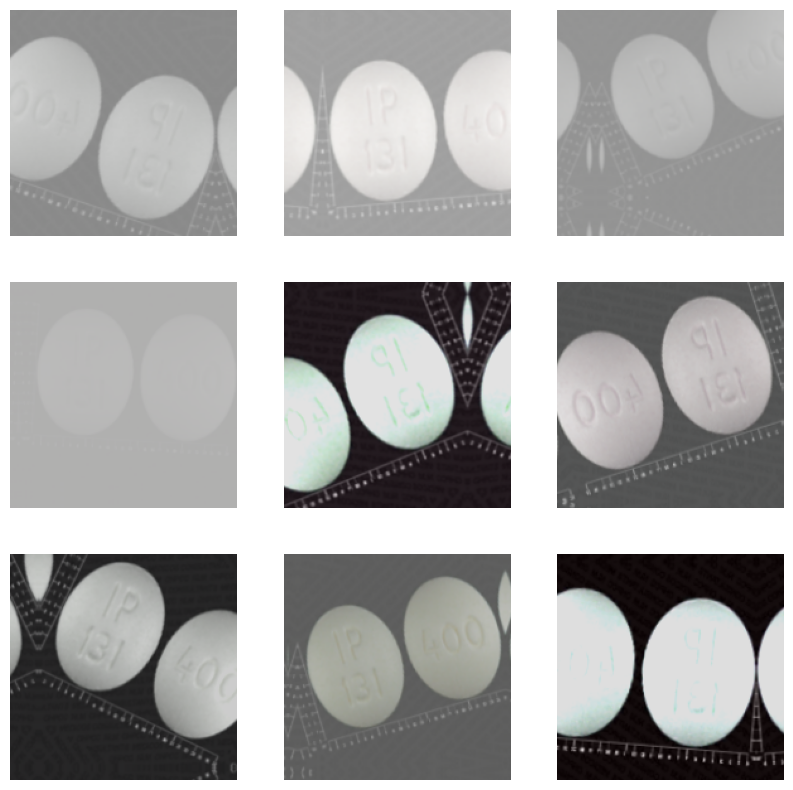

In [43]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(2):
  for i in range(9):
    augmented_images = data_augmentation2(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [166]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [10]:
def random_saturation(image):
    image = tf.image.random_saturation(image, lower=0.7, upper=1.3)
    return image
    
def random_color_jitter(image):
    image = tf.image.random_contrast(image, lower=0.2, upper=1.8)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_saturation(image, lower=0.2, upper=1.8)
    image = tf.image.random_hue(image, max_delta=0.2)
    return image

data_augmentation = tf.keras.Sequential([
    layers.Lambda(random_saturation, input_shape=(img_height, img_width, 3)),
    layers.Lambda(random_color_jitter, input_shape=(img_height, img_width, 3)),

    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2),
    layers.RandomCrop(img_height, img_width),
    # layers.RandomHeight(0.2),
    # layers.RandomWidth(0.2),
    layers.RandomTranslation(0.2, 0.2),
    layers.Rescaling(1./255)

    # use randombrightness, random contrast, random crop, randomflip, reandomheight, random rotation, random translation,random width, random zoom 
    # Add any other aggressive transformations you want to experiment with
])

In [11]:
num_classes = len(class_names)

model = Sequential([
    keras.Input(shape=(180, 180, 3)),
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

    data_augmentation,
    layers.Conv2D(32, 3, padding='same', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Activation('relu'),  # Use Activation layer
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Activation('relu'),  # Use Activation layer
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Activation('relu'),  # Use Activation layer
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(num_classes)
])


NameError: name 'class_names' is not defined

In [168]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [147]:
model.summary()

Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_46 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 sequential_53 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 conv2d_82 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 batch_normalization_67 (Ba  (None, 180, 180, 32)      128       
 tchNormalization)                                               
                                                                 
 activation_60 (Activation)  (None, 180, 180, 32)      0         
                                                                 
 max_pooling2d_81 (MaxPooli  (None, 90, 90, 32)        0         
 ng2D)                                               

In [180]:
callbacks = [EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]

epochs=50
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    # callbacks=callbacks
)

# Access training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


Epoch 1/50
7/7 [==============================] - 0s 24ms/step - loss: 0.3897 - accuracy: 0.8462 - val_loss: 0.1737 - val_accuracy: 1.0000
Epoch 2/50
7/7 [==============================] - 0s 28ms/step - loss: 0.3356 - accuracy: 0.8462 - val_loss: 0.3065 - val_accuracy: 1.0000
Epoch 3/50
7/7 [==============================] - 0s 22ms/step - loss: 0.3860 - accuracy: 0.8462 - val_loss: 0.3801 - val_accuracy: 1.0000
Epoch 4/50
7/7 [==============================] - 0s 23ms/step - loss: 0.3951 - accuracy: 0.8462 - val_loss: 0.3877 - val_accuracy: 1.0000
Epoch 5/50
7/7 [==============================] - 0s 25ms/step - loss: 0.3986 - accuracy: 0.8462 - val_loss: 0.3698 - val_accuracy: 1.0000
Epoch 6/50
7/7 [==============================] - 0s 23ms/step - loss: 0.3871 - accuracy: 0.8462 - val_loss: 0.3498 - val_accuracy: 1.0000
Epoch 7/50
7/7 [==============================] - 0s 25ms/step - loss: 0.3823 - accuracy: 0.8462 - val_loss: 0.3389 - val_accuracy: 1.0000
Epoch 8/50
7/7 [===========

ValueError: x and y must have same first dimension, but have shapes (50,) and (12,)

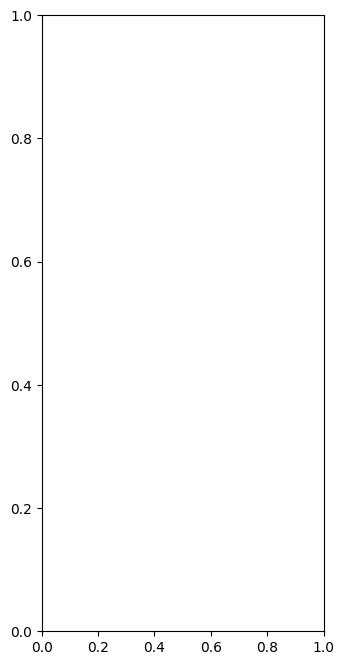

In [190]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [28]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

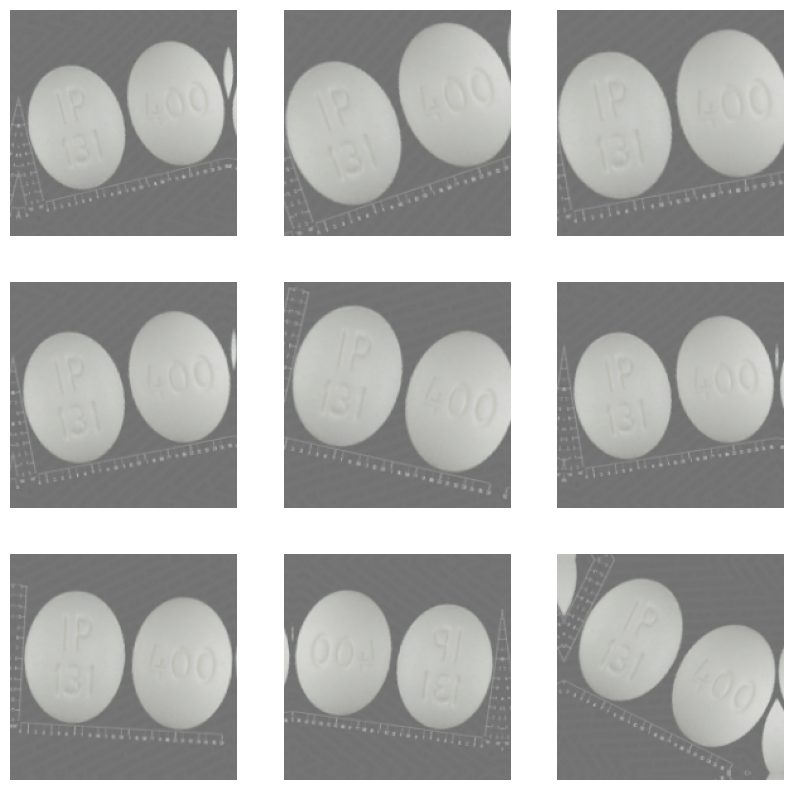

In [29]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [30]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [31]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [32]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_12 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 rescaling_16 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_21 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 90, 90, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                               

In [33]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
7/7 [==============================] - 1s 32ms/step - loss: 1.4243 - accuracy: 0.3077 - val_loss: 0.7420 - val_accuracy: 0.3333
Epoch 2/15
7/7 [==============================] - 0s 24ms/step - loss: 0.7089 - accuracy: 0.5385 - val_loss: 0.7396 - val_accuracy: 0.3333
Epoch 3/15
7/7 [==============================] - 0s 23ms/step - loss: 0.6540 - accuracy: 0.5385 - val_loss: 0.6653 - val_accuracy: 0.3333
Epoch 4/15
7/7 [==============================] - 0s 25ms/step - loss: 0.6678 - accuracy: 0.5385 - val_loss: 0.6064 - val_accuracy: 0.3333
Epoch 5/15
7/7 [==============================] - 0s 24ms/step - loss: 0.5694 - accuracy: 0.5385 - val_loss: 0.5592 - val_accuracy: 0.3333
Epoch 6/15
7/7 [==============================] - 0s 22ms/step - loss: 0.5593 - accuracy: 0.5385 - val_loss: 0.5017 - val_accuracy: 1.0000
Epoch 7/15
7/7 [==============================] - 0s 22ms/step - loss: 0.5786 - accuracy: 0.5385 - val_loss: 0.4754 - val_accuracy: 1.0000
Epoch 8/15
7/7 [===========

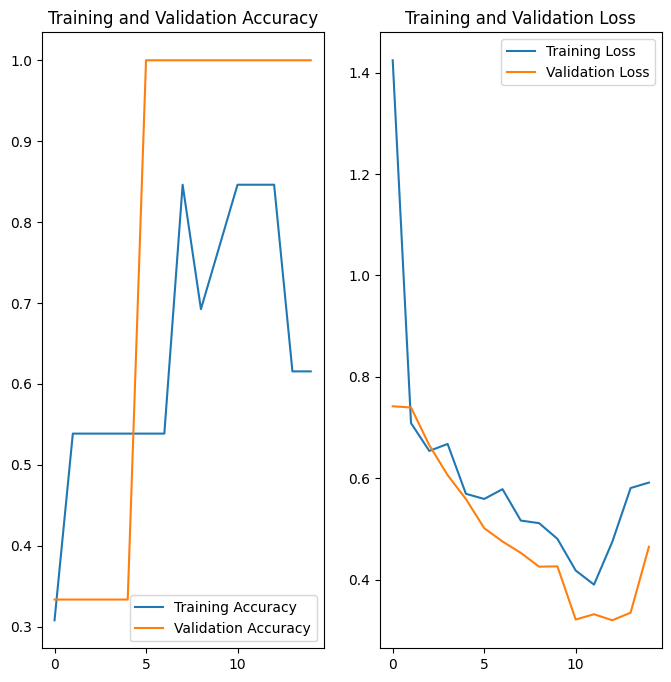

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [53]:
aspirin_url = "https://www.drugs.com/images/pills/nlm/50844-0600-01_NLMIMAGE10_CF38E7F7.jpg"
aspirin_path = tf.keras.utils.get_file('aspirin_try1', origin=aspirin_url)
print(aspirin_url)
print(aspirin_path)
img = tf.keras.utils.load_img(
    aspirin_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

https://www.drugs.com/images/pills/nlm/50844-0600-01_NLMIMAGE10_CF38E7F7.jpg
/Users/liangshenghao/.keras/datasets/aspirin_try1
1/1 [==============================] - 0s 153ms/step
This image most likely belongs to aspirin with a 54.52 percent confidence.


In [45]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/5d/52yrlx1d1sv318sd35fq_3rw0000gn/T/tmprlq2lme9/assets


INFO:tensorflow:Assets written to: /var/folders/5d/52yrlx1d1sv318sd35fq_3rw0000gn/T/tmprlq2lme9/assets
2024-02-15 23:14:23.051673: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2024-02-15 23:14:23.051921: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2024-02-15 23:14:23.052222: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/5d/52yrlx1d1sv318sd35fq_3rw0000gn/T/tmprlq2lme9
2024-02-15 23:14:23.053621: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2024-02-15 23:14:23.053625: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /var/folders/5d/52yrlx1d1sv318sd35fq_3rw0000gn/T/tmprlq2lme9
2024-02-15 23:14:23.059181: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2024-02-15 23:14:23.136464: I tensorflow/cc/saved_model/loader.cc:215] Running initialization

In [54]:
TF_MODEL_FILE_PATH = 'model.tflite' # The default path to the saved TensorFlow Lite model

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

In [55]:
interpreter.get_signature_list()

{'serving_default': {'inputs': ['sequential_12_input'],
  'outputs': ['outputs']}}

In [56]:
classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite

In [49]:
predictions_lite = classify_lite(sequential_1_input=img_array)['outputs']
score_lite = tf.nn.softmax(predictions_lite)

ValueError: Invalid Input name (sequential_1_input) for SignatureDef

In [50]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score_lite)], 100 * np.max(score_lite))
)

NameError: name 'score_lite' is not defined

In [32]:
print(np.max(np.abs(predictions - predictions_lite)))

3.7252903e-09


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


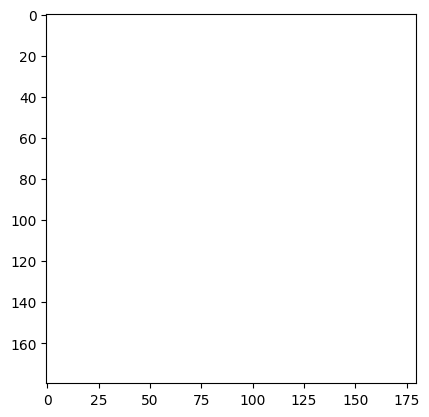

In [31]:
image, label = next(iter(train_ds))
_ = plt.imshow(image[1])


In [32]:
IMG_SIZE = 180

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])


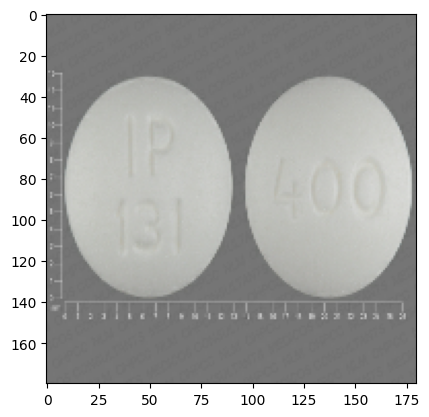

In [33]:
result = resize_and_rescale(image[1])
_ = plt.imshow(result)


In [36]:
print("Min and max pixel values:", result.numpy().min(), result.numpy().max())
print(type(image))
print(type(image[0]))
print(len(image))
print(len(image[0]))
image.shape


Min and max pixel values: 0.41372553 0.8619737
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
2
180


TensorShape([2, 180, 180, 3])

In [37]:
image[0].shape


TensorShape([180, 180, 3])

In [38]:
result.shape

TensorShape([180, 180, 3])

In [39]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [40]:
image = tf.cast(tf.expand_dims(image, 0), tf.float32)


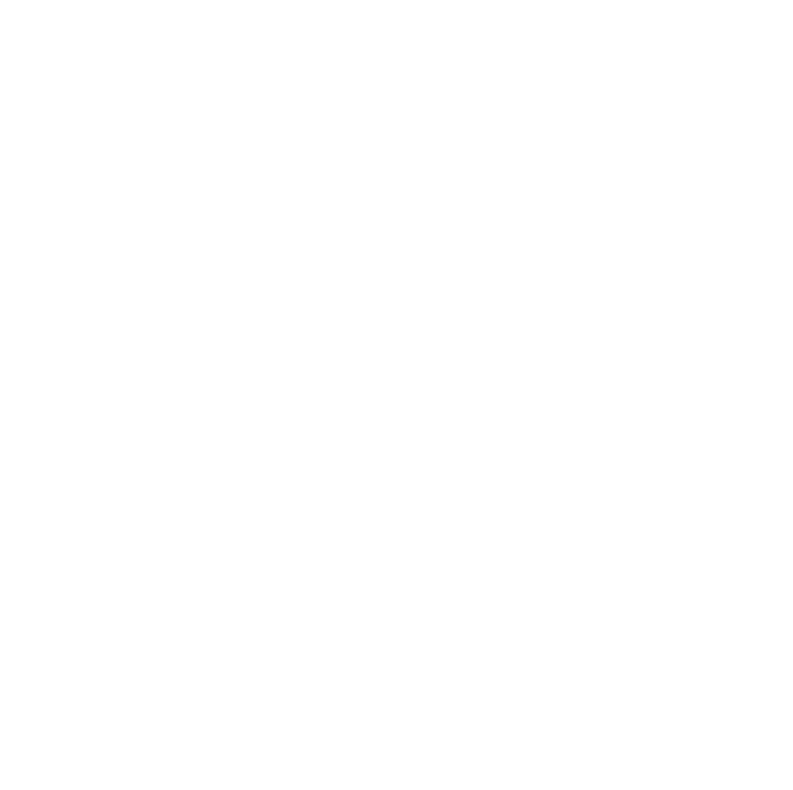

In [41]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image[0])
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

In [42]:
model = tf.keras.Sequential([
  # Add the preprocessing layers you created earlier.
  resize_and_rescale,
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  # Rest of your model.  
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [43]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [44]:
epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5
7/7 [==============================] - 1s 28ms/step - loss: 1.6738 - accuracy: 0.6154 - val_loss: 1.4142 - val_accuracy: 0.3333
Epoch 2/5
7/7 [==============================] - 0s 23ms/step - loss: 0.9823 - accuracy: 0.5385 - val_loss: 0.7753 - val_accuracy: 0.3333
Epoch 3/5
7/7 [==============================] - 0s 21ms/step - loss: 0.6932 - accuracy: 0.5385 - val_loss: 0.6664 - val_accuracy: 0.3333
Epoch 4/5
7/7 [==============================] - 0s 20ms/step - loss: 0.7127 - accuracy: 0.5385 - val_loss: 0.6704 - val_accuracy: 0.3333
Epoch 5/5
7/7 [==============================] - 0s 27ms/step - loss: 0.7190 - accuracy: 0.3077 - val_loss: 0.6161 - val_accuracy: 1.0000


In [45]:
loss, acc = model.evaluate(val_ds)
print("Accuracy", acc)

2/2 [==============================] - 0s 8ms/step - loss: 0.6161 - accuracy: 1.0000
Accuracy 1.0


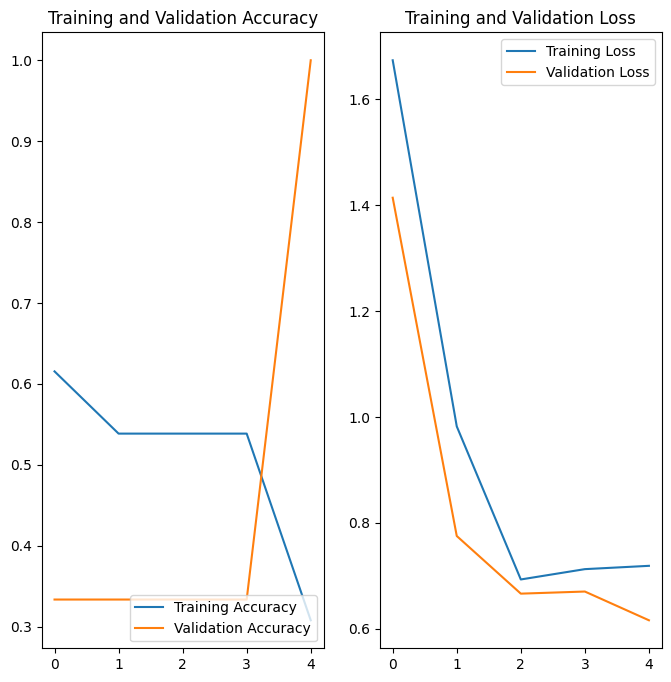

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [51]:
aspirin_url = "https://www.drugs.com/images/pills/nlm/50844-0600-01_NLMIMAGE10_CF38E7F7.jpg"
aspirin_path = tf.keras.utils.get_file('aspirin_try1', origin=aspirin_url)
print(aspirin_url)
print(aspirin_path)
img = tf.keras.utils.load_img(
    aspirin_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

https://www.drugs.com/images/pills/nlm/50844-0600-01_NLMIMAGE10_CF38E7F7.jpg
/Users/liangshenghao/.keras/datasets/aspirin_try1
1/1 [==============================] - 0s 41ms/step
This image most likely belongs to ibuprofan with a 55.93 percent confidence.


In [48]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (180, 180, 3)             0         
                                                                 
 sequential_4 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

In [49]:
def random_invert_img(x, p=0.5):
  if  tf.random.uniform([]) < p:
    x = (255-x)
  else:
    x
  return x

In [50]:
def random_invert(factor=0.5):
  return layers.Lambda(lambda x: random_invert_img(x, factor))

random_invert = random_invert()

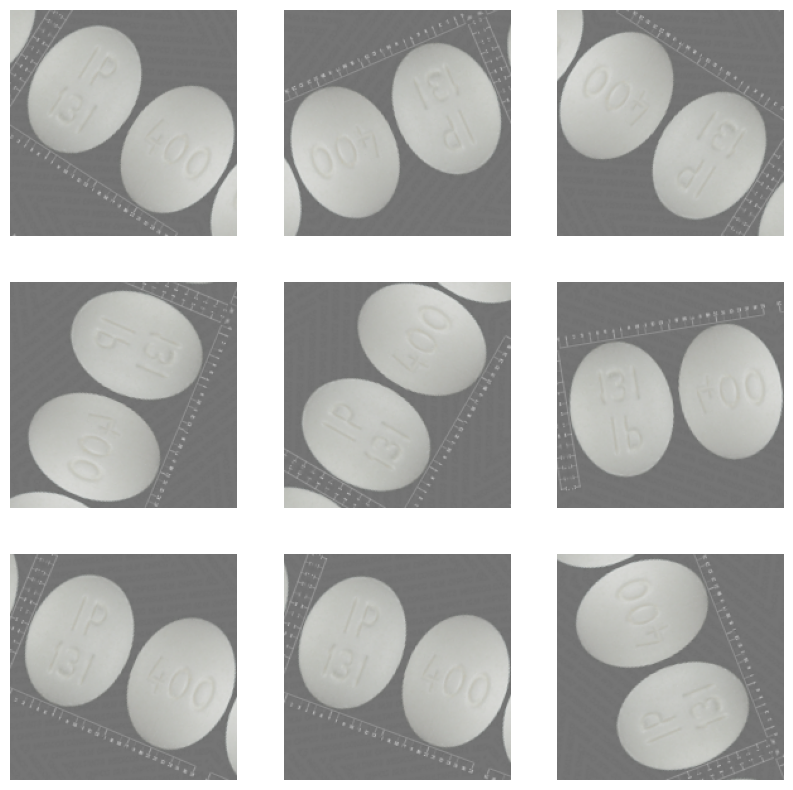

In [51]:
# plt.figure(figsize=(10, 10))
# for i in range(9):
#   ax = plt.subplot(3, 3, i + 1)
#   for j in range(len(image)):# because image is not a single item
#     augmented_image = random_invert(image[j])
#     plt.imshow(augmented_image[0].numpy().astype("uint8"))
#     plt.axis("off")
# or 
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


In [52]:
class RandomInvert(layers.Layer):
  def __init__(self, factor=0.5, **kwargs):
    super().__init__(**kwargs)
    self.factor = factor

  def call(self, x):
    return random_invert_img(x)

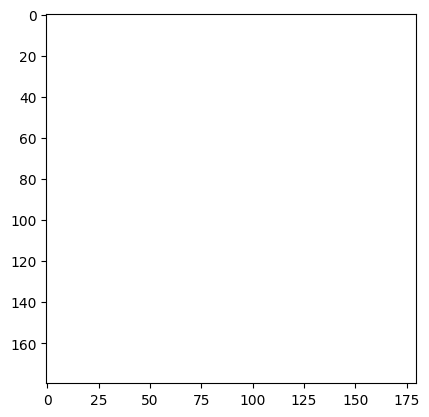

In [53]:
_ = plt.imshow(RandomInvert()(image[0])[0])
